In [1]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

In [2]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [4]:
class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

In [5]:
def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

In [6]:
class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

In [7]:
class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale 

In [8]:
class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [9]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [10]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

In [11]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes * 4, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

In [12]:
class ResNet(nn.Module):
    def __init__(self, block, layers,  network_type, num_classes, att_type=None):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.network_type = network_type
        # different model config between ImageNet and CIFAR 
        if network_type == "ImageNet":
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
            self.avgpool = nn.AvgPool2d(7)
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        if att_type=='BAM':
            self.bam1 = BAM(64*block.expansion)
            self.bam2 = BAM(128*block.expansion)
            self.bam3 = BAM(256*block.expansion)
        else:
            self.bam1, self.bam2, self.bam3 = None, None, None

        self.layer1 = self._make_layer(block, 64,  layers[0], att_type=att_type)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=1, att_type=att_type)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, att_type=att_type)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, att_type=att_type)

        self.fc = nn.Linear(512 * 16, num_classes)

        init.kaiming_normal(self.fc.weight)
        for key in self.state_dict():
            if key.split('.')[-1]=="weight":
                if "conv" in key:
                    init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if "bn" in key:
                    if "SpatialGate" in key:
                        self.state_dict()[key][...] = 0
                    else:
                        self.state_dict()[key][...] = 1
            elif key.split(".")[-1]=='bias':
                self.state_dict()[key][...] = 0

    def _make_layer(self, block, planes, blocks, stride=1, att_type=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam=att_type=='CBAM'))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam=att_type=='CBAM'))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.network_type == "ImageNet":
            x = self.maxpool(x)

        x = self.layer1(x)
        if not self.bam1 is None:
            x = self.bam1(x)

        x = self.layer2(x)
        if not self.bam2 is None:
            x = self.bam2(x)

        x = self.layer3(x)
        if not self.bam3 is None:
            x = self.bam3(x)

        x = self.layer4(x)

        if self.network_type == "ImageNet":
            x = self.avgpool(x)
        else:
            x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(block=BasicBlock, layers=[2, 2, 2, 2], network_type="ImageNet", num_classes=10, att_type='CBAM').to(device=device)

<ipython-input-12-6296b3a6eae5>:31: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
<ipython-input-12-6296b3a6eae5>:35: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


In [14]:
x = torch.randn(5, 3, 32, 32)
x = x.to(device=device)
y = model(x)
print(y.shape)
print(y)

torch.Size([5, 10])
tensor([[-0.3658,  1.6347, -0.2116, -0.3601,  0.8238,  0.2591,  0.0543,  0.4437,
          0.7351, -0.6414],
        [-0.2212,  1.1234, -0.1258, -0.5361,  0.6667,  0.6875, -0.0256,  0.7235,
          0.9592, -0.7400],
        [-0.2612,  0.8412,  0.3523, -0.2306,  0.8558,  0.6265, -0.0696,  0.4922,
          0.5252, -0.6840],
        [-0.5408,  1.3550, -0.2802, -0.5034,  0.9751,  0.7344, -0.4691,  0.4892,
          0.4525, -1.0335],
        [-0.4710,  1.6573, -0.0435, -0.3891,  1.1557,  0.2068, -0.1167,  0.3154,
          0.9702, -0.8924]], device='cuda:0', grad_fn=<AddmmBackward0>)


D:\anaconda3\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [15]:
import torchvision.datasets as datasets
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm

In [16]:
# Hyperparameters
in_channels = 3
num_classes = 10
learning_rate = 3e-4 # karpathy's constant
batch_size = 64
num_epochs = 50

In [17]:
train_dataset = datasets.CIFAR10(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [19]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [20]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

car


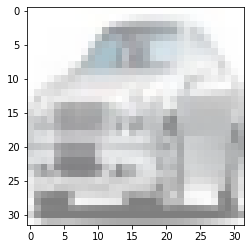

In [21]:
print(classes[labels[63]])
imshow(torchvision.utils.make_grid(images[63]))

In [22]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        
    print('Epoch:', epoch, 'Loss:', loss.item())

  0%|                                                                                          | 0/782 [00:00<?, ?it/s]D:\anaconda3\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Loss: 1.4334079027175903


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Loss: 0.9151611924171448


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Loss: 0.5014353394508362


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Loss: 0.3523091971874237


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Loss: 0.4797744154930115


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Loss: 0.24148842692375183


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Loss: 0.3070489764213562


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Loss: 0.3766407370567322


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Loss: 0.38802340626716614


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Loss: 0.3326217830181122


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Loss: 0.05931917577981949


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Loss: 0.14295797049999237


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Loss: 0.053858861327171326


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Loss: 0.08612824976444244


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Loss: 0.05387325584888458


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Loss: 0.0853491723537445


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Loss: 0.1943759024143219


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Loss: 0.2074141800403595


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Loss: 0.017675362527370453


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Loss: 0.0031924000941216946


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 20 Loss: 0.02022795006632805


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 21 Loss: 0.39919689297676086


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 22 Loss: 0.05281304568052292


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 23 Loss: 0.004805368836969137


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 24 Loss: 0.004976054187864065


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 25 Loss: 0.009986103512346745


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 26 Loss: 0.03213266655802727


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 27 Loss: 0.0004718401760328561


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 28 Loss: 0.007798671722412109


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 29 Loss: 0.15912702679634094


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 30 Loss: 0.0786258652806282


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 31 Loss: 0.0013812737306579947


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 32 Loss: 0.006967108231037855


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 33 Loss: 0.11218132823705673


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 34 Loss: 0.002584554720669985


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 35 Loss: 0.010422655381262302


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 36 Loss: 0.038503482937812805


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 37 Loss: 0.0003804722800850868


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 38 Loss: 0.0014627112541347742


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 39 Loss: 0.00781935267150402


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 40 Loss: 0.00013176842185202986


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 41 Loss: 0.0016417730366811156


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 42 Loss: 0.004043079912662506


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 43 Loss: 0.04259394481778145


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 44 Loss: 0.0007068238919600844


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 45 Loss: 0.13360466063022614


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 46 Loss: 0.1663050353527069


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 47 Loss: 0.21520094573497772


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 48 Loss: 0.002458510920405388


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [09:11<00:00,  1.42it/s]

Epoch: 49 Loss: 0.0011774972081184387


In [24]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

index number: 0


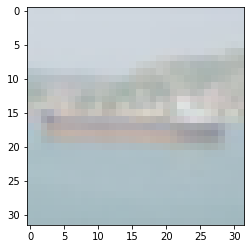

true label: ship
predict label: ship
index number: 1


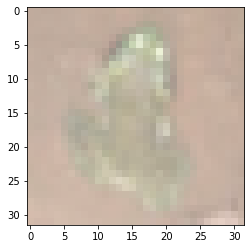

true label: frog
predict label: frog
index number: 2


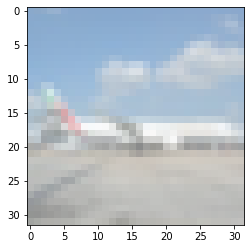

true label: plane
predict label: plane
index number: 3


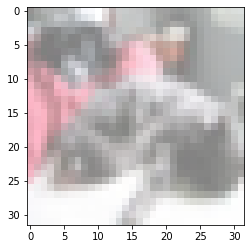

true label: cat
predict label: truck
index number: 4


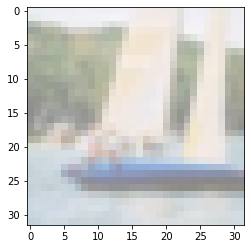

true label: ship
predict label: ship
index number: 5


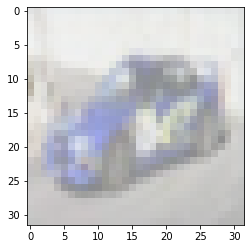

true label: car
predict label: car
index number: 6


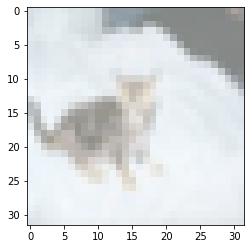

true label: cat
predict label: cat
index number: 7


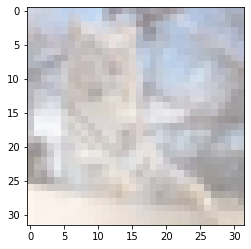

true label: cat
predict label: cat
index number: 8


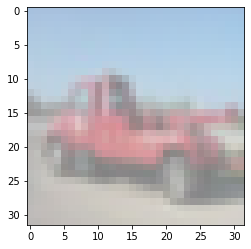

true label: truck
predict label: truck
index number: 9


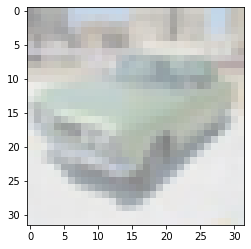

true label: car
predict label: car
index number: 10


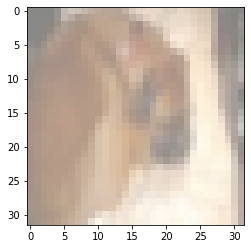

true label: dog
predict label: dog
index number:  


In [25]:
while True:
    i = input("index number: ")
    if i == ' ':
        break
    i = int(i)
    imshow(torchvision.utils.make_grid(images[i]))
    print('true label:',classes[labels[i]])
    prediction = model(images.to(device=device))
    max_index = np.argmax(prediction[i,:].cpu().detach().numpy())
    print('predict label:',classes[max_index])